In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('dataset/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0000,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,...,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,0.0000,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,...,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,1.0000,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,...,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,1.0000,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,...,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,2.0000,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,...,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0


In [2]:
card_df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df):
    df_copy = df.copy()
    df_copy.drop('Time',axis=1,inplace=True)
    return df_copy

In [8]:
def get_train_test_dataset(df):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X_features,y_target,test_size=0.3,
                                                    random_state=0,stratify=y_target)
    return X_train,X_test,y_train,y_test
X_train,X_test,y_train,y_test = get_train_test_dataset(card_df)

In [9]:
print(y_train.shape)
y_train.value_counts()

(199364,)


0    199020
1       344
Name: Class, dtype: int64

In [10]:
print('학습 레이블 비율\n', y_train.value_counts()/y_train.shape[0]*100)
print('테스트 레이블 비율\n', y_test.value_counts()/y_test.shape[0]*100)

학습 레이블 비율
 0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 레이블 비율
 0    99.826785
1     0.173215
Name: Class, dtype: float64


In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score, \
f1_score, roc_auc_score

def get_clf_eval(y_test,pred,pred_proba):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    
    print('오차행렬\n', confusion)
    print('정확도: {:.4f}, 정밀도: {:.4f}, 재현율: {:.4f}, f1: {:.4f}, auc:{:.4}'
          .format(accuracy,precision,recall,f1,roc_auc))


In [14]:
# 로지스틱 리그레션
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred_lr = lr_clf.predict(X_test)
pred_proba_lr = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test,pred_lr,pred_proba_lr)

오차행렬
 [[85281    14]
 [   61    87]]
정확도: 0.9991, 정밀도: 0.8614, 재현율: 0.5878, f1: 0.6988, auc:0.9563


In [59]:
# 인자로 estimator 객체와 학습/테스트 세트를 입력받아 학습/예측/평가 수행하는 사용자 함수
def get_model_train_eval(model, ftr_train, ftr_test, tgt_train, tgt_test):
    model.fit(ftr_train,tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test,pred,pred_proba)

In [16]:
# 레이블 값이 극도로 불균형한 분포를 가지고 있는 경우 boost_from_average=False로 파라미터 설정
# (default=True)
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,X_train,X_test,y_train,y_test)

오차행렬
 [[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, f1: 0.8453, auc:0.979


<AxesSubplot:xlabel='Amount', ylabel='Density'>

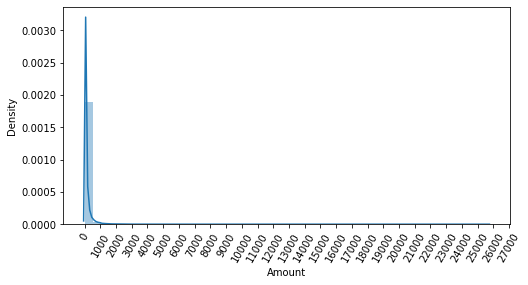

In [17]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

In [19]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n) # Amount_Scaled 칼럼값으로 amount_n 데이터를 공통적으로 집어넣는다.
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [20]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False) # n_estimator 반복 수행 트리 개수
# num_leaves 하나의 트리가 가질 수 있는 최대 리프 개수
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차행렬
 [[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, f1: 0.7143, auc:0.9702
### LightGBM 예측 성능 ###
오차행렬
 [[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500, f1: 0.8409, auc:0.9779


In [21]:
# 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법중의 하나
def get_preprocessed_df(df):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [22]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차행렬
 [[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, f1: 0.7149, auc:0.9727
### LightGBM 예측 성능 ###
오차행렬
 [[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, f1: 0.8496, auc:0.9796


<AxesSubplot:>

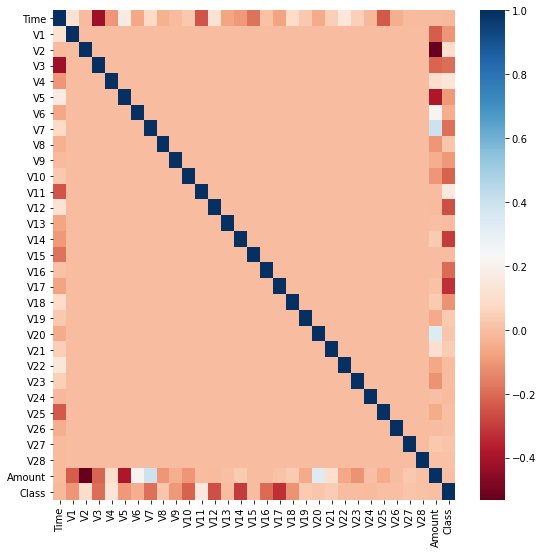

In [23]:
# 이상치 제거 후 모델 학습/예측/평가
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
# print(corr)
sns.heatmap(corr, cmap='RdBu')

In [29]:
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [38]:
# 상관관계가 높은 컬럼에 대한 이상치
pd.options.display.float_format = '{:.4f}'.format
# pd.reset_option('display.float_format')
card_df[['V14','V17']].describe()

,V14,V17
count,284807.0000,284807.0000
mean,0.0000,-0.0000
std,0.9586,0.8493
min,-19.2143,-25.1628
25%,-0.4256,-0.4837
50%,0.0506,-0.0657
75%,0.4931,0.3997
max,10.5268,9.2535


In [32]:
card_df[['V14','V17']].head()

,V14,V17
0,-0.311169,0.207971
1,-0.143772,-0.114805
2,-0.165946,1.109969
3,-0.287924,-0.684093
4,-1.119670,-0.237033


<AxesSubplot:>

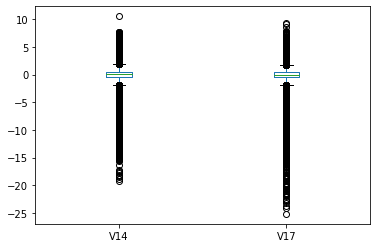

In [35]:
card_df[['V14','V17']].plot(kind='box')

<AxesSubplot:>

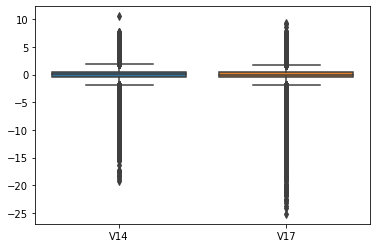

In [34]:
sns.boxplot(data=card_df[['V14','V17']])

In [51]:
import numpy as np

def get_outlier(df, column, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [52]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [60]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차행렬
 [[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, f1: 0.7597, auc:0.9743
### LightGBM 예측 성능 ###
오차행렬
 [[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288, f1: 0.8897, auc:0.978


In [61]:
# SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
# SMOTE 적용 시 반드시 학습 데이터 세트만 오버 샘플링

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [62]:
# 오버 샘플링된 데이터로 학습 시 재현율이 크게 증가하지만 정밀도가 급격하게 감소
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,X_train_over,X_test,y_train_over,y_test)

오차행렬
 [[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, f1: 0.1023, auc:0.9737


In [63]:
lgbm_clf = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,X_train_over,X_test,y_train_over,y_test)

오차행렬
 [[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, f1: 0.8794, auc:0.9814
